In [17]:
# Notebook setup
%load_ext autoreload
%autoreload 2
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from cerebra_atlas_python.utils import setup_logging
setup_logging(level="DEBUG")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Imports
import os
import os.path as op
import logging

import mne
import numpy as np
from mne import bem

from cerebra_atlas_python.mni_average import MNIAverage
from cerebra_atlas_python.cerebra import get_label_details, get_cerebra_volume
from cerebra_atlas_python.utils import inspect_img

Freesurfer and MNE must be installed 

## Constants

Datasets:
- [CerebrA](https://gin.g-node.org/anamanera/CerebrA/src/master/): $CEREBRA_DIR
- [ICBM 2009c Nonlinear Symmetric [NIFTI]](https://nist.mni.mcgill.ca/icbm-152-nonlinear-atlases-2009/): $ICBM_DIR

In [19]:
# Datasets
ICBM_DIR = op.join(os.getenv("DATASETS_DIR"),"ICBM_2009c_Nonlinear_Symmetric/mni_icbm152_nlin_sym_09c_nifti")
CEREBRA_DIR = op.join(os.getenv("DATASETS_DIR"),"Cerebra")

# FreeSurfer
FS_SUBJECTS_DIR = os.getenv("SUBJECTS_DIR")
NEW_SUBJECT_NAME = "icbm152" # Used by FreeSurfer
NEW_FS_SUBJECT_DIR = op.join(FS_SUBJECTS_DIR,NEW_SUBJECT_NAME)
BEM_DIR = op.join(NEW_FS_SUBJECT_DIR, "bem")

# Output dir
CEREBRA_DATA_DIR = "../cerebra_atlas_python/cerebra_data"
CEREBRA_DATA_SUBJECT_DIR = op.join(CEREBRA_DATA_DIR, "subjects", NEW_SUBJECT_NAME)
HEAD_MRI_T_PATH = op.join(CEREBRA_DATA_SUBJECT_DIR,"head_mri_t.fif")
FIDUCIALS_PATH = op.join(CEREBRA_DATA_SUBJECT_DIR,"bem/icbm152-fiducials.fif")
INFO_PATH = op.join(CEREBRA_DATA_DIR,"info.fif")
LABEL_DETAILS_PATH = op.join(CEREBRA_DATA_DIR,"label_details.csv")
CEREBRA_VOLUME_PATH = op.join(CEREBRA_DATA_DIR,"volume.npy")
MONTAGE_KIND = "GSN-HydroCel-129"
MONTAGE_HEAD_SIZE = 0.1025

# MNIAverage (icbm152)

#### Run fs recon-all

In [20]:
subject_dir = op.join(FS_SUBJECTS_DIR, NEW_SUBJECT_NAME)
if op.exists(subject_dir):
    logging.info("%s FreeSurfer subject already exists, skipping recon-all", NEW_SUBJECT_NAME)
else:
    logging.info("Running recon-all for %s", NEW_SUBJECT_NAME)
    !recon-all -subjid icbm152 -i $ICBM_DIR/mni_icbm152_t1_tal_nlin_sym_09c.nii -all
    !mkdir -p $CEREBRA_DATA_DIR/subjects/$NEW_SUBJECT_NAME/mri
    !cp $NEW_FS_SUBJECT_DIR/mri/T1.mgz $CEREBRA_DATA_DIR/subjects/$NEW_SUBJECT_NAME/mri/T1.mgz
    !cp $NEW_FS_SUBJECT_DIR/mri/wm.asegedit.mgz $CEREBRA_DATA_DIR/subjects/$NEW_SUBJECT_NAME/mri/wm.mgz

 [INFO] 2023-12-08 00:42:29.867 329260797 - <module>: icbm152 FreeSurfer subject already exists, skipping recon-all


#### Run mne.bem.make_watershed_bem 
BEM surfaces were generated using the FreeSurfer watershed algorithm through MNE's `mne.bem.make_watershed_bem` and then manually edited so that all inner surfaces are contained within the outer surfaces as explained [here](https://mne.tools/stable/auto_tutorials/forward/80_fix_bem_in_blender.html).

In [21]:
if op.exists(BEM_DIR):
    logging.info("BEM surfaces for subject %s already exist, skipping make_watershed_bem", NEW_SUBJECT_NAME)
else: 
    logging.info("Running make_watershed_bem for %s", NEW_SUBJECT_NAME)
    bem.make_watershed_bem(NEW_SUBJECT_NAME)
    !mkdir -p $CEREBRA_DATA_DIR/subjects/$NEW_SUBJECT_NAME/bem
    !cp $NEW_FS_SUBJECT_DIR/bem/* $CEREBRA_DATA_DIR/subjects/$NEW_SUBJECT_NAME/bem

 [INFO] 2023-12-08 00:42:29.881 1340249944 - <module>: BEM surfaces for subject icbm152 already exist, skipping make_watershed_bem


<div style="display:flex;align-items:center;justify-content:center;background-color:black;padding:25px;flex-direction:column"><img src="../images/bem_manual_edit.png" alt="BEM MANUAL EDIT" width=50%></img><br/><small>Manual editing of BEM surfaces produced by make_watershed_bem</small></div>

#### Create info (head size)

In [22]:
# Remove chin and neck
# TODO: Insert reference
electrode_names = [
        "E1",
        "E2",
        "E3",
        "E4",
        "E5",
        "E6",
        "E7",
        "E8",
        "E9",
        "E10",
        "E11",
        "E12",
        "E13",
        "E14",
        "E15",
        "E16",
        "E18",
        "E19",
        "E20",
        "E21",
        "E22",
        "E23",
        "E24",
        "E25",
        "E26",
        "E27",
        "E28",
        "E29",
        "E30",
        "E31",
        "E32",
        "E33",
        "E34",
        "E35",
        "E36",
        "E37",
        "E38",
        "E39",
        "E40",
        "E41",
        "E42",
        "E43",
        "E44",
        "E45",
        "E46",
        "E47",
        "E50",
        "E51",
        "E52",
        "E53",
        "E54",
        "E55",
        "E57",
        "E58",
        "E59",
        "E60",
        "E61",
        "E62",
        "E64",
        "E65",
        "E66",
        "E67",
        "E69",
        "E70",
        "E71",
        "E72",
        "E74",
        "E75",
        "E76",
        "E77",
        "E78",
        "E79",
        "E80",
        "E82",
        "E83",
        "E84",
        "E85",
        "E86",
        "E87",
        "E89",
        "E90",
        "E91",
        "E92",
        "E93",
        "E95",
        "E96",
        "E97",
        "E98",
        "E100",
        "E101",
        "E102",
        "E103",
        "E104",
        "E105",
        "E106",
        "E108",
        "E109",
        "E110",
        "E111",
        "E112",
        "E114",
        "E115",
        "E116",
        "E117",
        "E118",
        "E120",
        "E121",
        "E122",
        "E123",
        "E124",
        "Cz",
    ]

In [23]:
if op.exists(INFO_PATH):
    logging.info("BEM surfaces for subject %s already exist, skipping make_watershed_bem", NEW_SUBJECT_NAME)
else:
    from cerebra_atlas_python.utils import get_standard_montage
    logging.info("Creating info file for %s", NEW_SUBJECT_NAME)
    montage = get_standard_montage(electrode_names,kind=MONTAGE_KIND,head_size=MONTAGE_HEAD_SIZE)
    kept_ch_names = montage.ch_names
    info = mne.create_info(kept_ch_names, 5000, ch_types='eeg', verbose=False)
    info.set_montage(montage)
    info.save(INFO_PATH)


 [INFO] 2023-12-08 00:42:29.908 4125258872 - <module>: BEM surfaces for subject icbm152 already exist, skipping make_watershed_bem


#### Manually align fiducials
Produces 

subjects/icbm152/bem/icbm152-fiducials.fif 
and
head_mri_t.fif

In [24]:
# Save fiducials to $bem_dir/icbm152-fiducials.fif
# Save fiducials to $./head_mri_t.fif
if not op.exists(FIDUCIALS_PATH) or not op.exists(HEAD_MRI_T_PATH):
    import mne
    mne.gui.coregistration()
else:
    
    logging.info("Fiducials and head to mri transform already exists %s and %s", FIDUCIALS_PATH, HEAD_MRI_T_PATH)

 [INFO] 2023-12-08 00:42:29.920 1426419388 - <module>: Fiducials and head to mri transform already exists ../cerebra_atlas_python/cerebra_data/subjects/icbm152/bem/icbm152-fiducials.fif and ../cerebra_atlas_python/cerebra_data/subjects/icbm152/head_mri_t.fif


In [25]:


mni_average = MNIAverage()
mni_average.head_mri_t

 [DEBUG] 2023-12-08 00:42:29.934 config - __init__: Value for variable cerebra_data_path not provided in config.ini[MNIAverage]. Defaulting to cerebra_data_path=/home/carlos/Carlos/cerebra_atlas_python/cerebra_atlas_python/cerebra_data
 [INFO] 2023-12-08 00:42:29.934 mni_average - _set_bem: Loading boundary element model from disk | MNIAverage_bem_0.33_0.0042_0.33_ico_4
 [DEBUG] 2023-12-08 00:42:30.12 mni_average - _set_fiducials: Fiducials coordinate frame: 5 (FIFFV_COORD_MRI)


<Transform | head->MRI (surface RAS)>
[[ 0.99998409  0.00051499 -0.00561859 -0.00032736]
 [-0.00093964  0.99711949 -0.07584107 -0.00204062]
 [ 0.00556335  0.07584514  0.99710411 -0.05805472]
 [ 0.          0.          0.          1.        ]]

In [26]:
mne.dig_mri_distances(mni_average.info, mni_average.head_mri_t, mni_average.subject_name).sum()
mne.viz.plot_alignment(bem=mni_average.bem, mri_fiducials=mni_average.fiducials, trans=mni_average.head_mri_t, show_axes=True,dig=True, info = mni_average.info)

 [DEBUG] 2023-12-08 00:42:30.342 __init__ - _load_stylesheet: Reading QSS file in: :qdarkstyle/dark/darkstyle.qss
 [INFO] 2023-12-08 00:42:30.343 __init__ - _load_stylesheet: QSS file successfully loaded.
 [DEBUG] 2023-12-08 00:42:30.343 __init__ - _load_stylesheet: Checking patches for being applied.
 [INFO] 2023-12-08 00:42:30.343 __init__ - _apply_version_patches: Found version patches to be applied.
 [INFO] 2023-12-08 00:42:30.343 __init__ - _apply_application_patches: Found application patches to be applied.


# CerebrA 


#### Process labels

In [27]:
label_details_path = op.join(CEREBRA_DIR, "CerebrA_LabelDetails.csv")
processed_label_details = get_label_details(label_details_path)
processed_label_details

,Mindboggle ID,Label Name,CerebrA ID,hemisphere,cortical,color
0,0.0,Empty,0,,False,#000000
1,2027.0,Rostral Middle Frontal,1,Right,True,#ff001e
2,631.0,Vermal lobules VI-VII,2,Right,False,#ff0013
3,2009.0,Inferior temporal,3,Right,True,#ff0003
4,58.0,Accumbens Area,4,Right,False,#ff0700
...,...,...,...,...,...,...
99,53.0,Hippocampus,99,Left,False,#ff00f0
100,50.0,Caudate,100,Left,False,#ff00e5
101,630.0,Vermal lobules I-V,101,Left,False,#ff00d4
102,1031.0,Supramarginal,102,Left,True,#ff00ca


In [28]:
processed_label_details.to_csv(LABEL_DETAILS_PATH)

#### Process volume

In [29]:
!mri_convert $CEREBRA_DIR"/CerebrA.nii" $CEREBRA_DIR"/CerebrA.mgz"
!mri_vol2vol --mov $CEREBRA_DIR"/CerebrA.mgz" --o $CEREBRA_DATA_DIR"/CerebrA_in_head.mgz" --regheader --targ $NEW_FS_SUBJECT_DIR/mri/T1.mgz --interp nearest

mri_convert /home/carlos/Datasets/Cerebra/CerebrA.nii /home/carlos/Datasets/Cerebra/CerebrA.mgz 
reading from /home/carlos/Datasets/Cerebra/CerebrA.nii...


TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (0, 0, 1)
writing to /home/carlos/Datasets/Cerebra/CerebrA.mgz...
movvol /home/carlos/Datasets/Cerebra/CerebrA.mgz
targvol /home/carlos/Datasets/subjects/icbm152/mri/T1.mgz
outvol ../cerebra_atlas_python/cerebra_data/CerebrA_in_head.mgz
invert 0
tal    0
talres 2
regheader 1
noresample 0
interp  nearest (0)
precision  float (3)
Gdiag_no  -1
Synth      0
SynthSeed  1702081148

Computing registration based on scanner-to-scanner

Final tkRAS-to-tkRAS Matrix is:
-1.00000   0.00000   0.00000   0.00000;
 0.00000   0.00000   1.00000   0.00000;
 0.00000  -1.00000   0.00000   0.00000;
 0.00000   0.00000   0.00000   1.00000;


Vox2Vox Matrix is:
-1.00000   0.00000   0.00000   224.50000;
 0.00000   0.00000   1.00000  -13.50000;
 0.00000  -1.00000   0.00000   224.50000;
 0.00000   0.00000   0.00000   1.00000;

Resampling
Output registration matrix is identity

mri_vol2vol done


 [INFO] 2023-12-08 00:47:07.490 utils - inspect_img: img.shape= (193, 229, 193)
 [INFO] 2023-12-08 00:47:07.491 utils - inspect_img: Coordinate frame: RAS
 [INFO] 2023-12-08 00:47:07.491 utils - inspect_img: 
[[   1.    0.    0.  -96.]
 [   0.    1.    0. -132.]
 [   0.    0.    1.  -78.]
 [   0.    0.    0.    1.]]


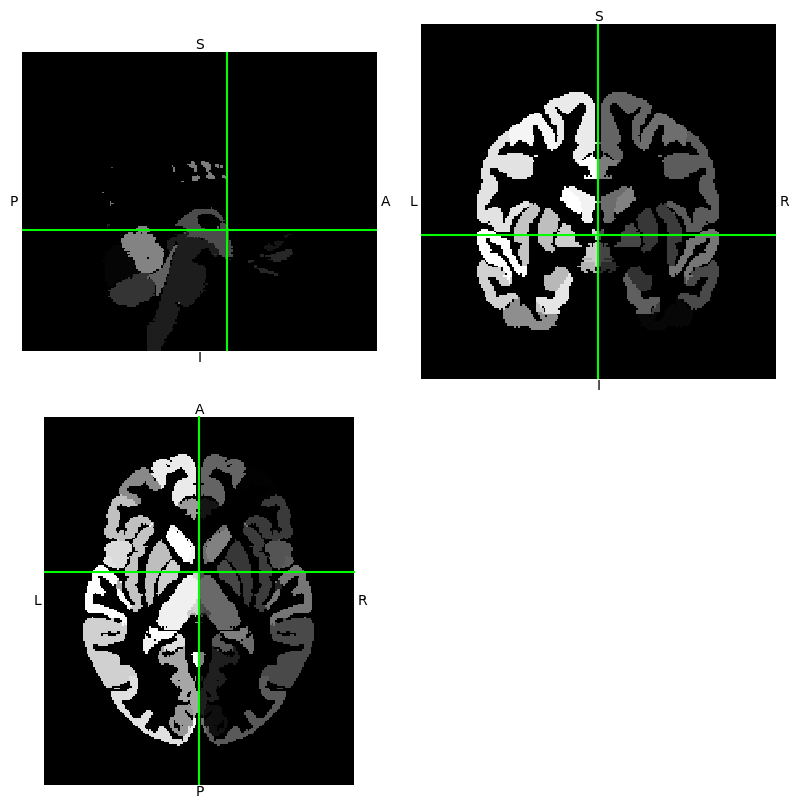

In [34]:
inspect_img(f"{CEREBRA_DIR}/CerebrA.mgz")
pass

 [INFO] 2023-12-08 00:42:32.132 utils - inspect_img: img.shape= (256, 256, 256)
 [INFO] 2023-12-08 00:42:32.133 utils - inspect_img: Coordinate frame: LIA
 [INFO] 2023-12-08 00:42:32.134 utils - inspect_img: 
[[  -1.     0.     0.   128.5]
 [   0.     0.     1.  -145.5]
 [   0.    -1.     0.   146.5]
 [   0.     0.     0.     1. ]]


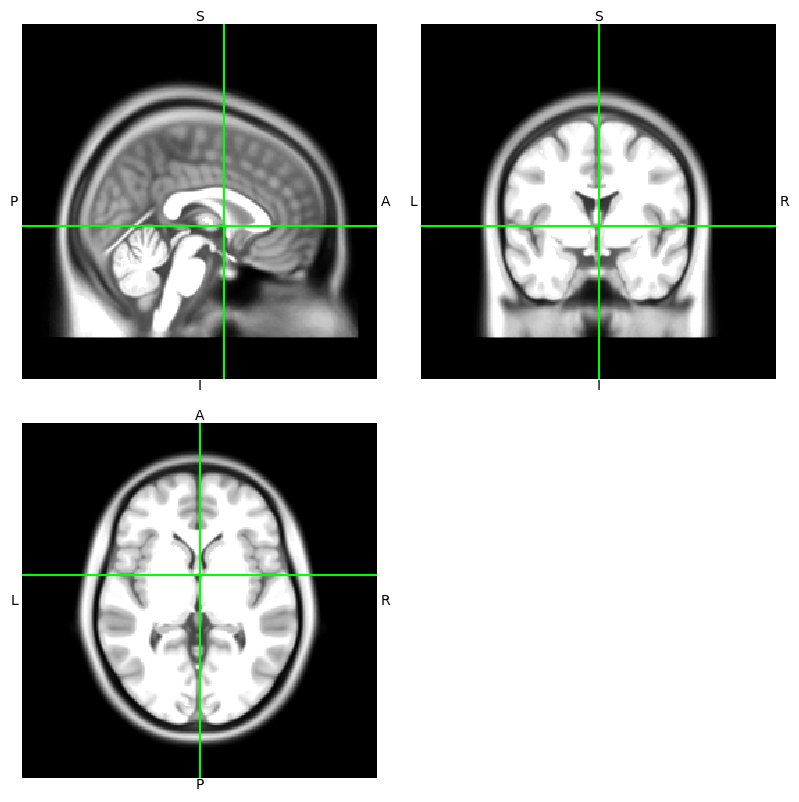

In [30]:
inspect_img(f"{CEREBRA_DATA_SUBJECT_DIR}/mri/T1.mgz")
pass

 [INFO] 2023-12-08 00:42:32.787 utils - inspect_img: img.shape= (256, 256, 256)
 [INFO] 2023-12-08 00:42:32.788 utils - inspect_img: Coordinate frame: LIA
 [INFO] 2023-12-08 00:42:32.788 utils - inspect_img: 
[[  -1.     0.     0.   128.5]
 [   0.     0.     1.  -145.5]
 [   0.    -1.     0.   146.5]
 [   0.     0.     0.     1. ]]


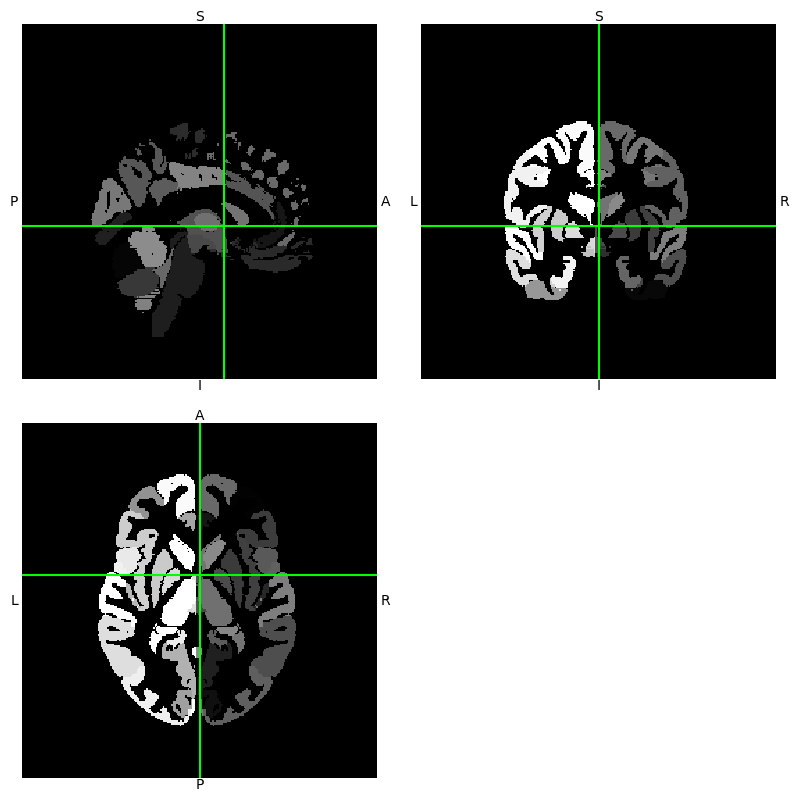

In [31]:
inspect_img(f"{CEREBRA_DIR}/CerebrA_in_head.mgz")
pass

 [INFO] 2023-12-08 00:42:33.55 utils - inspect_img: img.shape= (256, 256, 256)
 [INFO] 2023-12-08 00:42:33.56 utils - inspect_img: Coordinate frame: LIA
 [INFO] 2023-12-08 00:42:33.57 utils - inspect_img: 
[[  -1.     0.     0.   128.5]
 [   0.     0.     1.  -145.5]
 [   0.    -1.     0.   146.5]
 [   0.     0.     0.     1. ]]


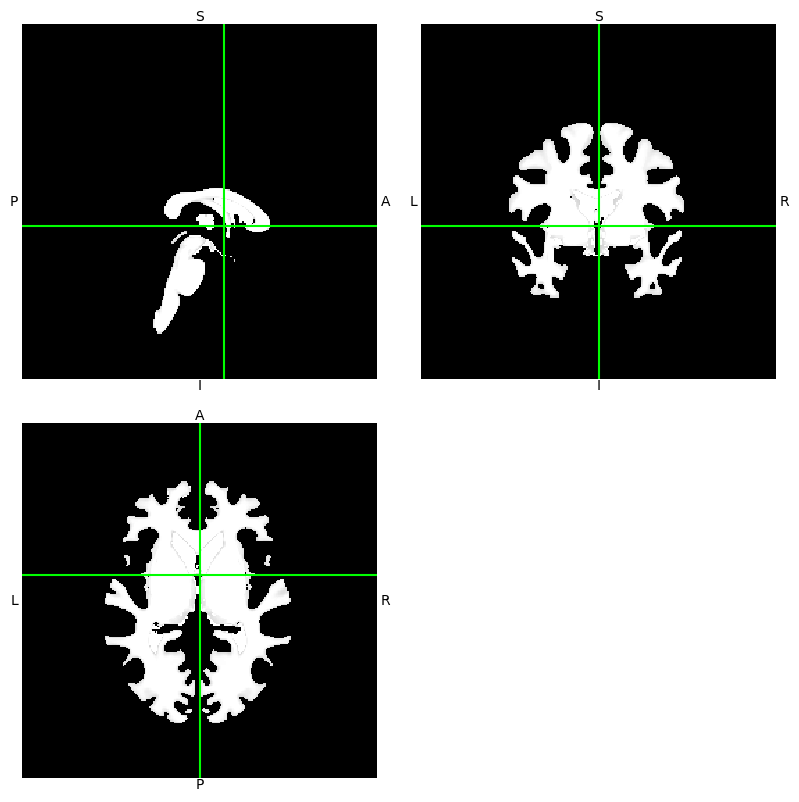

In [32]:
inspect_img(f"{CEREBRA_DATA_SUBJECT_DIR}/mri/wm.mgz")
pass